Restoring RP images by calculating and using Pseudo-invers matrix. After restoring the image, visually compare the RP image with the restored one.

擬似逆行列の生成 <br>
http://programming.blogo.jp/python/numpy/擬似逆行列

scipy.sparseの内部構造 <br>
http://hamukazu.com/2014/12/03/internal-data-structure-scipy-sparse/

画像の品質評価 MSE, SSIM, PSNR, pixel difference <br>
https://qiita.com/redshoga/items/5e36d784a322c940f38e

In [32]:
import os 
import cv2
import re
import csv
import time
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.random_projection import johnson_lindenstrauss_min_dim, SparseRandomProjection, GaussianRandomProjection

warnings.filterwarnings("ignore")

main_folder_path = "/Users/yuunin/Downloads/SVM/CroppedYale/"

labels = []
images = []

for subfolders in os.listdir(main_folder_path):
    if subfolders != ".DS_Store":
        for image_name in os.listdir(main_folder_path + subfolders):
            # もし画像データ(画素値とか)まで欲しかったらここで読み込んでappend
            image = cv2.imread(main_folder_path + subfolders + "/" + image_name, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (50, 50))
            images.append(image.flatten())
            labels.append(re.sub(r"[a-zA-Z]", "", subfolders))

images_dataset = np.array(images)
images_dataset.shape

(2470, 2500)

# Visual comparison of original and restored image (Sparse Random Projection)


original image   (32, 32)


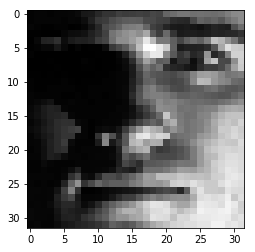

Randomly Projected image   (32, 32)


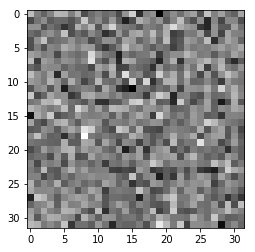

In [2]:
#showing original image 
org_img = images[0]
org_img = np.reshape(org_img, [32, 32])
print("original image   {0}".format(org_img.shape))
plt.imshow(org_img)
plt.gray() ####
plt.show()

#generate SRM(sparse random matrix) and showing random mapped image
img_1 = np.reshape(images[0], [1, 1024])
transformer = SparseRandomProjection(n_components = 1024,
                                     density = 'auto',
                                     eps = 0.1,
                                     random_state = 42,
                                    )
img_2 = transformer.fit_transform(img_1)
img_3 = np.reshape(img_2, [32, 32])
print("Randomly Projected image   {0}".format(img_3.shape))
plt.imshow(img_3)
plt.gray()
plt.show()

s = 32 <br>
density = 1 / s <br>

            
SRM :  √s * 

In [3]:
print(img_2.shape)
print(transformer.components_.shape)
print(transformer.density_)
print(transformer.components_)

(1, 1024)
(1024, 1024)
0.03125
  (0, 531)	0.1767766952966369
  (0, 819)	-0.1767766952966369
  (0, 453)	0.1767766952966369
  (0, 31)	0.1767766952966369
  (0, 625)	0.1767766952966369
  (0, 594)	0.1767766952966369
  (0, 993)	0.1767766952966369
  (0, 848)	-0.1767766952966369
  (0, 76)	-0.1767766952966369
  (0, 237)	0.1767766952966369
  (0, 377)	0.1767766952966369
  (0, 70)	-0.1767766952966369
  (0, 685)	-0.1767766952966369
  (0, 101)	-0.1767766952966369
  (0, 628)	0.1767766952966369
  (0, 660)	-0.1767766952966369
  (0, 529)	0.1767766952966369
  (0, 305)	0.1767766952966369
  (0, 411)	0.1767766952966369
  (0, 174)	-0.1767766952966369
  (0, 96)	0.1767766952966369
  (0, 359)	-0.1767766952966369
  (0, 404)	0.1767766952966369
  (0, 536)	0.1767766952966369
  (0, 764)	0.1767766952966369
  :	:
  (1022, 300)	-0.1767766952966369
  (1022, 320)	0.1767766952966369
  (1023, 602)	-0.1767766952966369
  (1023, 980)	-0.1767766952966369
  (1023, 811)	-0.1767766952966369
  (1023, 360)	0.1767766952966369
  (102

In [4]:
#transfering SRM to new list (up to 5min)
SRM = []
for i in range(0, 1024):
    for j in range(0, 1024):
        SRM.append(transformer.components_[i, j])
print(len(SRM))

#convert to numpy array and reshape
SRM = np.array(SRM)
SRM = np.reshape(SRM, [1024, 1024])

#writing SRM to csv file
with open('SRP_matrix.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(SRM)

1048576


In [5]:
#generate pseudo-inverse matrix of SRP_matrix
Pinverse = np.linalg.pinv(SRM)
print(Pinverse.shape)
Pinverse_t = Pinverse.T
print(Pinverse_t.shape)

(1024, 1024)
(1024, 1024)


orginal img   (32, 32)


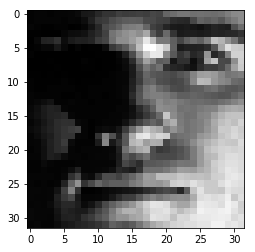

restored img   (32, 32)


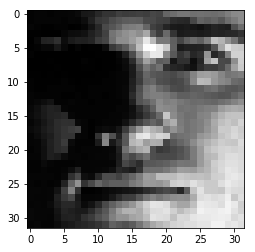

MSE : 2.732019208162701e-23
PSNR : 273.7659661242879
Pixel Difference : 4.2212029427446396e-09


In [38]:
#img_2(1, 256) * Pinverse_t(256, 1024) -- if blocksize = 32
img_4 = np.dot(img_2, Pinverse_t)
img_4 = np.reshape(img_4, [32, 32])
print("orginal img   {0}".format(org_img.shape))
plt.imshow(org_img)
plt.show()
print("restored img   {0}".format(img_4.shape))
plt.imshow(img_4)
plt.show()

#calculate psnr 
def compare_img(img1, img2):
    mse = np.mean((img1-img2)**2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    pix_diff = np.sum(np.absolute(img1-img2))
    print("MSE : {0}\nPSNR : {1}\nPixel Difference : {2}".format(mse, psnr, pix_diff))

compare_img(org_img, img_4)

## restoring dimensionality reduced images

original image (32, 32)


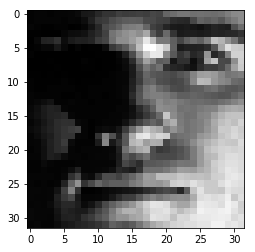

randomly projected image (30, 30)


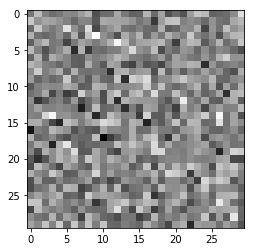

921600
(1024, 900)
(900, 1024)
restored image (32, 32)


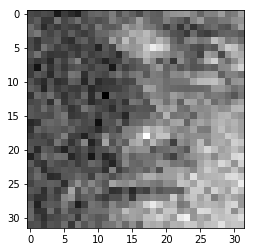

In [11]:
#return Random projected image

def SRM_img(img, blocksize):
    show_img(img, "original image")
    img = np.reshape(img, [1, 32 * 32])
    transformer = SparseRandomProjection(n_components = blocksize*blocksize,
                                         density = 'auto',
                                         eps = 0.1,
                                         random_state = 42,
                                        )
    img = transformer.fit_transform(img)
    img_ = np.reshape(img, [blocksize, blocksize])
    show_img(img_, "randomly projected image")
    SRM_ = []
    for i in range(0, blocksize * blocksize):
        for j in range(0, 32 * 32):
            SRM_.append(transformer.components_[i, j])
    print(len(SRM_))

    #convert to numpy array and reshape
    SRM_ = np.array(SRM_)
    SRM_ = np.reshape(SRM_, [blocksize*blocksize, 32 * 32])
    Pinverse = np.linalg.pinv(SRM_)
    print(Pinverse.shape)
    Pinverse_t = Pinverse.T
    print(Pinverse_t.shape)
    img_ = np.dot(img, Pinverse_t)
    img_ = np.reshape(img_, [32, 32])
    show_img(img_, "restored image")
    
def show_img(img, img_type):
    print(img_type, img.shape)
    plt.imshow(img)
    plt.show()
        
SRM_img(org_img, 30)
#SRM_img(org_img, 8)


original image (32, 32)


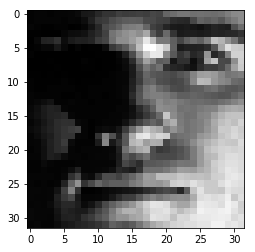

randomly projected image (31, 31)


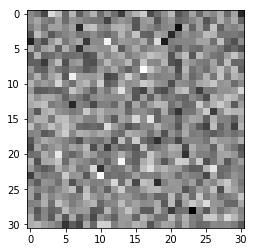

984064
(1024, 961)
(961, 1024)
restored image (32, 32)


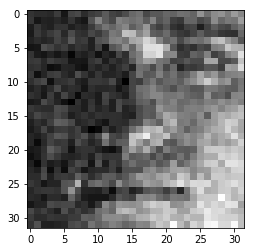

In [12]:
SRM_img(org_img, 31)

In [39]:
def SRM_img_50(img, blocksize):
    show_img(img, "original image")
    img = np.reshape(img, [1, 50 * 50])
    transformer = SparseRandomProjection(n_components = blocksize*blocksize,
                                         density = 'auto',
                                         eps = 0.1,
                                         random_state = 42,
                                        )
    img = transformer.fit_transform(img)
    img_ = np.reshape(img, [blocksize, blocksize])
    show_img(img_, "randomly projected image")
    SRM_ = []
    for i in range(0, blocksize * blocksize):
        for j in range(0, 50 * 50):
            SRM_.append(transformer.components_[i, j])
    print(len(SRM_))

    #convert to numpy array and reshape
    SRM_ = np.array(SRM_)
    SRM_ = np.reshape(SRM_, [blocksize*blocksize, 50 * 50])
    Pinverse = np.linalg.pinv(SRM_)
    print(Pinverse.shape)
    Pinverse_t = Pinverse.T
    print(Pinverse_t.shape)
    img_ = np.dot(img, Pinverse_t)
    img_ = np.reshape(img_, [50, 50])
    show_img(img_, "restored image")
    return img_
    
def show_img(img, img_type):
    print(img_type, img.shape)
    plt.imshow(img)
    plt.show()

original image (50, 50)


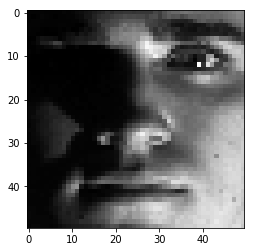

randomly projected image (45, 45)


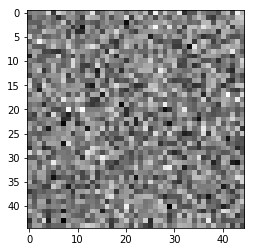

5062500
(2500, 2025)
(2025, 2500)
restored image (50, 50)


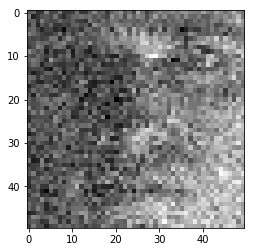

In [40]:
org_img_50 = np.reshape(images[0], [50, 50])
img_50to45 = SRM_img_50(org_img_50, 45)

In [41]:
compare_img(org_img_50, img_50to45)

MSE : 779.2936093399516
PSNR : 19.213792460810243
Pixel Difference : 55958.4082986992


In [24]:
import random

#create 1024x256 matrix
sparse_matrix = np.zeros([1024, 256])
print(sparse_matrix.shape)

num_ones = 0
num_minus_ones = 0

while num_ones < 4096:
    #randint[a, b] includes both a and b
    if sparse_matrix[random.randint(0, 1023), random.randint(0, 255)] != 1 and -1: 
        sparse_matrix[random.randint(0, 1023), random.randint(0, 255)] = 1
        num_ones = num_ones + 1
        
while num_minus_ones < 4096:
    if sparse_matrix[random.randint(0, 1023), random.randint(0, 255)] != 1 and -1:
        sparse_matrix[random.randint(0, 1023), random.randint(0, 255)] = -1
        num_minus_ones = num_minus_ones + 1
        

sparse_matrix = np.sqrt(32) / np.sqrt(16 * 16) * sparse_matrix
with open('sparse_matix.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(sparse_matrix)

(1024, 256)


In [ ]:
img_5 = img_1
print(img_5.shape)

img_6 = np.dot(img_5, sparse_matrix)

print(img_6.shape)

img_7 = np.reshape(img_6, [16, 16])
plt.imshow(img_7)
plt.gray()
plt.show()

In [ ]:
Pinverse = np.linalg.pinv(sparse_matrix)
print(Pinverse.shape)

In [ ]:
img_6    #1x256

img_8 = np.dot(img_6, Pinverse)

print(img_8.shape)
img_9 = np.reshape(img_8, [32, 32])
plt.imshow(img_9)
plt.show()

In [ ]:
SRM_16 = []
for i in range(0, ):
    for j in range(0, 1024):
        SRM.append(transformer.components_[i, j])
print(len(SRM))

#convert to numpy array and reshape
SRM = np.array(SRM)
SRM = np.reshape(SRM, [1024, 1024])

# Visual comparison of original and restored image (Random Projection)

In [26]:
def RM_img(img, blocksize):
    show_img(img, "original image")
    img = np.reshape(img, [1, 32 * 32])
    transformer = GaussianRandomProjection(n_components = blocksize*blocksize,
                                         eps = 0.1,
                                         random_state = 42,
                                        )
    img = transformer.fit_transform(img)
    img_ = np.reshape(img, [blocksize, blocksize])
    show_img(img_, "randomly projected image")
    RM_ = []
    for i in range(0, blocksize * blocksize):
        for j in range(0, 32 * 32):
            RM_.append(transformer.components_[i, j])
    print(len(RM_))

    #convert to numpy array and reshape
    RM_ = np.array(RM_)
    RM_ = np.reshape(RM_, [blocksize*blocksize, 32 * 32])
    Pinverse = np.linalg.pinv(RM_)
    print(Pinverse.shape)
    Pinverse_t = Pinverse.T
    print(Pinverse_t.shape)
    img_ = np.dot(img, Pinverse_t)
    img_ = np.reshape(img_, [32, 32])
    show_img(img_, "restored image")

original image (32, 32)


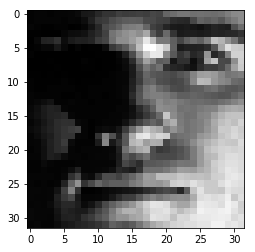

randomly projected image (30, 30)


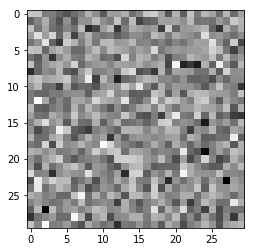

921600
(1024, 900)
(900, 1024)
restored image (32, 32)


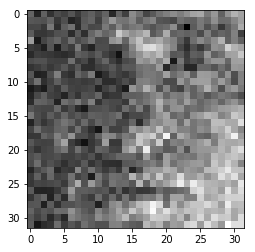

In [29]:
RM_img(org_img, 30)

* unflatten the image values stored in dtst_reduce
* visually compare the images by showing them
* build the model by best error rate than accuracy
* ROC, AUC, precision, recall
* output training accuracy and validation accuracy 
* stochastic gradient descent 
* images loaded in OpenCV = BGR / images loaded in matplotlib = RGB ・・ color distortion occurs if not converted

In [ ]:
num_comp = 192 #削減率 81%
ACC_SRP = []
TIME_SRP = []
ACC_RP = []
TIME_RP = []